
# Neural XC training: KSR model 

We retrace the steps of the original KSR model in the paper:
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.036401

To showcase the training process we only use 2 epochs.

The following steps are performed:

1. Load configuration
2. Load dataset
3. Define model
4. Train model

The models are saved in the `tests/ksr/ckpts` directory.

The states of evaluated model are saved in the `tests/ksr/states.pkl` file.

In [1]:
import os
import sys
from pathlib import Path

import glob
import json
import pickle
import time

import jax
from jax import random
from jax import tree_util
from jax import config
import jax.numpy as jnp
from jax_dft import datasets
from jax_dft import jit_scf
from jax_dft import losses
from jax_dft import neural_xc
from jax_dft import np_utils
from jax_dft import scf
from jax_dft import utils
from jax_dft import xc
import matplotlib.pyplot as plt
import numpy as np
import scipy

import qedft
from qedft.config.config import Config
from qedft.data_io.dataset_loader import load_molecular_datasets_from_config
from qedft.train.od.train import create_kohn_sham_fn, create_loss_fn, create_training_step
# Set the default dtype as float64
config.update('jax_enable_x64', True)

# Get the project path
import qedft
project_path = os.path.dirname(os.path.dirname(qedft.__file__))
print(f"Project path: {project_path}")


Project path: /Users/igorsokolov/PycharmProjects/qex


In [2]:
# Initialize a configuration object to manage our settings
# Define the project path, assuming 'settings.yaml' is located in the root directory
project_path = Path(os.path.dirname(os.path.dirname(qedft.__file__)))
# Load configuration settings from a YAML file
config = Config(config_path=project_path / 'qedft' / 'config' / 'train_config.yaml')
config_dict = config.config
config_dict

{'name': 'test',
 'experiment_name': 'test',
 'network_type': 'ksr',
 'molecule_name': 'h2',
 'molecule_names': ['h2'],
 'dataset1': [128, 384],
 'rng': 0,
 'save_plot_loss': False,
 'save_every_n': 20,
 'activation': 'tanh',
 'n_neurons': 513,
 'n_layers': 2,
 'n_qubits': 9,
 'n_reupload_layers': 1,
 'use_rzz_parametrized_entanglers': False,
 'chebychev_reuploading': False,
 'add_reversed_rzz': False,
 'entangling_block_type': 'alternate_linear',
 'single_qubit_rotations': ['rz', 'rx', 'rz'],
 'use_same_parameters': False,
 'add_negative_transform': False,
 'wrap_with_self_interaction_layer': False,
 'wrap_with_global_functional': False,
 'use_correlators_in_output': False,
 'output_operators': ['Z'],
 'use_bias_in_output': False,
 'max_train_steps': 10000,
 'factr': 1.0,
 'pgtol': 1e-14,
 'm': 20,
 'maxfun': 20,
 'maxiter': 2,
 'num_iterations': 15,
 'ks_iter_to_ignore': 10,
 'discount_factor': 0.9,
 'alpha': 0.5,
 'alpha_decay': 0.9,
 'num_mixing_iterations': 1,
 'density_mse_conver

## Loading dataset
Same distances as in the KSR paper.

In [3]:
config_dict['dataset1'] = [128, 384]

In [4]:
# Load datasets
base_path = project_path / "data" / "od"
base_path = Path(base_path)
list_datasets = load_molecular_datasets_from_config(
    config_dict,
    base_path,
    check_grid_centering=True
)
list_datasets

2025-06-11 13:56:19.783 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:63 - Loading dataset for h2
2025-06-11 13:56:19.785 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:83 - Loading dataset from /Users/igorsokolov/PycharmProjects/qex/data/od/h2
2025-06-11 13:56:19.788 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:95 - Training distances: [128, 384]
2025-06-11 13:56:19.789 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:101 - Number of electrons: 2
2025-06-11 13:56:19.789 | INFO     | qedft.data_io.dataset_loader:load_molecular_datasets:102 - Grid shape: (513,)


[(<jax_dft.datasets.Dataset at 0x10387b3a0>,
  KohnShamState(density=array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], shape=(2, 513)), total_energy=array([-2.06208973, -1.57112312]), locations=array([[-0.64,  0.64],
         [-1.92,  1.92]]), nuclear_charges=array([[1, 1],
         [1, 1]], dtype=int32), external_potential=array([[-0.00041461, -0.00042875, -0.00044337, ..., -0.00044337,
          -0.00042875, -0.00041461],
         [-0.00053689, -0.0005552 , -0.00057414, ..., -0.00057414,
          -0.0005552 , -0.00053689]], shape=(2, 513)), grids=array([[-20.48, -20.4 , -20.32, ...,  20.32,  20.4 ,  20.48],
         [-20.48, -20.4 , -20.32, ...,  20.32,  20.4 ,  20.48]],
        shape=(2, 513)), num_electrons=array([2, 2]), hartree_potential=None, xc_potential=None, xc_energy_density=None, gap=None, converged=array([ True,  True])))]

In [5]:
dataset = list_datasets[0][0]  # first dataset
train_set = list_datasets[0][1]  # KohnShamState object
train_set.grids[0][213]

np.float64(-3.44)

In [6]:
# Same grids for all datasets
grids = dataset.grids
print(f"Grids: {len(grids)}")
# exact density
# initial_density = scf.get_initial_density(train_set, method='exact')
# or
# noninteracting density
initial_density = scf.get_initial_density(train_set, method='noninteracting')
initial_density  # initial density for training set

# save initial density
# with open('initial_density.pkl', 'wb') as f:
#     pickle.dump(initial_density, f)


Grids: 513


Array([[1.36119039e-28, 5.94445108e-28, 1.41265059e-27, ...,
        1.41169566e-27, 5.94277752e-28, 1.35987023e-28],
       [1.93532725e-23, 8.40951795e-23, 1.98255792e-22, ...,
        1.98255588e-22, 8.40953719e-23, 1.93532880e-23]], dtype=float64)

(2, 513)


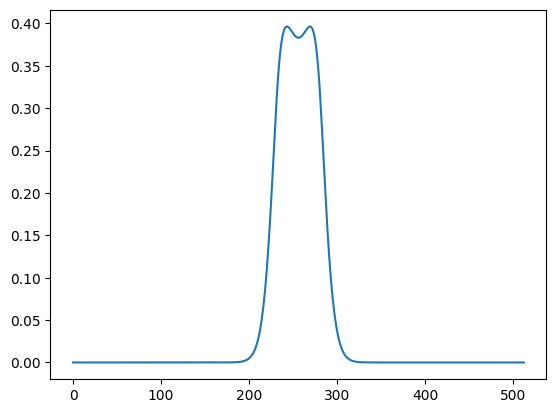

In [7]:
# Plot initial density
print(initial_density.shape)
plt.plot(initial_density[2])
plt.show()

## Training the KSR model

In [8]:
from qedft.models.classical.global_ksr_model import create_ksr_model_from_config

# Create KSR model
network, init_fn, neural_xc_energy_density_fn = create_ksr_model_from_config(grids)
network

(<function jax.example_libraries.stax.serial.<locals>.init_fun(rng, input_shape)>,
 <function jax.example_libraries.stax.serial.<locals>.apply_fun(params, inputs, **kwargs)>)

### Self-interaction layer
Layer used in the KSR model in addition to the negativity transform.
```python 
                                 Input
                                   │
                                   ▼
                              ┌─FanOut(2)─┐
                              │           │
                              ▼           ▼
                         Identity      Network
                              │           │
                              ▼           ▼
                       ┌─self_interaction_layer─┐
                       │                        │
                       ▼                        ▼
                    (density)               (features)
                       │                        │
                       └────────────┬───────────┘
                                    │
                                    ▼
                                  Output
```

Model prone to get stuck in local minima, try different initializations.

In [9]:
# Initialize parameters
prng = random.PRNGKey(1)
init_params = init_fn(prng)
spec, flatten_init_params = np_utils.flatten(init_params)
inputs = jax.random.uniform(
    prng,
    minval=-4 * jnp.pi,
    maxval=4 * jnp.pi,
    shape=(513,),
)
params = init_fn(prng)
print(f'Number of parameters: {len(flatten_init_params)}')
print(
    "Result of applying the model to 513 inputs: ",
    neural_xc_energy_density_fn(inputs, params),
)
initial_checkpoint_index = 0

Number of parameters: 1568
Result of applying the model to 513 inputs:  [-4.68033061e-02  2.50146253e-01  1.34800365e-01  1.87676751e-01
  1.42793586e-01 -4.34060384e-01 -1.60199802e+00 -3.05935782e+00
 -4.53275744e+00 -1.62967793e-01  3.72621485e-02  2.67694978e-01
  6.82410312e-02  7.13170101e-02  1.48744302e-02  1.10592108e-02
 -9.64942990e-02 -9.54277584e-01 -7.28130336e-01  1.95982878e-01
  2.13470589e-01  2.00985302e-01  2.77754668e-01  1.62564337e-01
  2.78198761e-01  3.02523036e-02  2.52585144e-01 -3.20720136e-02
  9.69492627e-02  1.06530726e-01  4.15163425e-02 -1.75642060e-01
 -1.81623394e-01 -3.46109357e-01  1.40025123e-01  2.29547403e-02
 -1.95308795e-01 -1.64032293e-01  1.31086810e-01 -1.78261078e-02
  3.14133304e-02  2.13294291e-02  8.84707718e-02 -3.75496328e-01
 -1.12511450e-02  8.31043013e-02  1.94697454e-01  2.72730961e-01
  1.61037688e-01  2.61915687e-01 -1.63613863e-01  2.20153098e-01
 -1.54116140e-02  2.77087283e-01  1.53538136e-01  2.73927533e-01
 -5.33931132e-02  

In [10]:
# jit the neural network apply function
neural_xc_energy_density_fn = jax.jit(neural_xc_energy_density_fn)
# evaluate the energy density
energy_density = neural_xc_energy_density_fn(inputs, params)
energy_density.shape

(513,)

In [11]:
# Create Kohn-Sham function and its batched version
kohn_sham_fn, batch_kohn_sham = create_kohn_sham_fn(
    config_dict, dataset, grids, neural_xc_energy_density_fn, spec)

In [12]:
# Create and initialize loss function
loss_fn = create_loss_fn(batch_kohn_sham, grids, dataset, config_dict)

In [13]:
# Create value and gradient function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

In [14]:
# Create training step function
training_step = create_training_step(
    value_and_grad_fn, train_set, initial_density, save_every_n=2, initial_checkpoint_index=0, checkpoint_dir=project_path / 'tests' / 'ksr' / 'ckpts', spec=spec
)

## Load the checkpoint 

In [15]:
# from qedft.train.od.eval import load_model_params

# # Load checkpoint
# try:
#     path_to_ckpt = str(project_path) + '/tests/ksr/ckpts/ckpt-00020'
#     params = load_model_params(path_to_ckpt)
#     _, flatten_init_params = np_utils.flatten(params)
# except:
#     print("No checkpoint found. Training from scratch.")
#     _, flatten_init_params = np_utils.flatten(params)


## Launching the training

In [16]:
# Optimize using L-BFGS-B

# x is the optimized parameters
# f is the value of the loss function at the optimized parameters
# info is the information about the optimization

x, f, info = scipy.optimize.fmin_l_bfgs_b(
    training_step,
    x0=np.array(flatten_init_params),
    maxfun=2,  # 200
    factr=1,  # 1e12 factr * machine epsilon (1e-15) = tolerance
    m=20,  # 10
    pgtol=1e-14,
    maxiter=2  # 200
)
x, f,info

2025-06-11 13:56:20.957 | INFO     | qedft.train.od.train:_kohn_sham:116 - Jitting kohn_sham_func
2025-06-11 13:56:32.172 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 0, loss 0.6052363609336104 in 4.5195629596710205 sec
2025-06-11 13:56:32.214 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/ksr/ckpts/ckpt-00000
2025-06-11 13:56:37.554 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 1, loss 0.28684514833272196 in 0.001522064208984375 sec
2025-06-11 13:56:43.164 | INFO     | qedft.train.od.train:np_value_and_grad_fn:454 - step 2, loss 0.11458070812956717 in 0.0005598068237304688 sec
2025-06-11 13:56:43.181 | INFO     | qedft.train.od.train:np_value_and_grad_fn:458 - Save checkpoint /Users/igorsokolov/PycharmProjects/qex/tests/ksr/ckpts/ckpt-00002


(array([-0.02341817,  0.01809271,  0.02007321, ...,  0.04923625,
         0.26186888,  1.18369054], shape=(1568,)),
 0.11458070812956717,
 {'grad': array([ 6.21408295e-04, -3.42754204e-04, -7.07117311e-04, ...,
         -6.11803716e-02,  6.69410351e-02, -7.74743541e-01], shape=(1568,)),
  'task': 'STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT',
  'funcalls': 3,
  'nit': 2,
  'warnflag': 1})

## Evaluating the trained model

In [17]:
from qedft.train.od.eval import eval_trained_model

# Plotting the states of the Kohn-Sham calculation for a given distance.
plot_distances = [40, 88, 128, 184, 232, 384, 400, 504, 584] #@param
plot_set = dataset.get_molecules(plot_distances)
plot_initial_density = scf.get_initial_density(
    plot_set, method='noninteracting')
nuclear_energy = utils.get_nuclear_interaction_energy_batch(
    plot_set.locations,
    plot_set.nuclear_charges,
    interaction_fn=utils.exponential_coulomb)
path_to_ckpt = str(project_path) + '/tests/ksr/ckpts/ckpt-00002'

In [18]:
# Evaluating the trained model for a given distance.
states = eval_trained_model(
    ckpt_path=path_to_ckpt,
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=neural_xc_energy_density_fn,
    use_amplitude_encoding=False,
    use_lda=False,
    alpha=config_dict['alpha'],
    alpha_decay=config_dict['alpha_decay'],
    num_mixing_iterations=1,
    density_mse_converge_tolerance=config_dict['density_mse_converge_tolerance'],
    enforce_reflection_symmetry=config_dict['enforce_reflection_symmetry'],
    output_path=project_path / 'tests' / 'ksr' / 'states.pkl'
)

2025-06-11 13:56:43.743 | INFO     | qedft.train.od.eval:load_model_params:102 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qex/tests/ksr/ckpts/ckpt-00002
2025-06-11 13:56:43.744 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 40
2025-06-11 13:56:45.371 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 88
2025-06-11 13:56:46.192 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 128
2025-06-11 13:56:46.907 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 184
2025-06-11 13:56:47.610 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 232
2025-06-11 13:56:48.426 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 384
2025-06-11 13:56:49.172 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 400
2025-06-11 13:56:49.943 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 504
2025-06-11 13:56:50.665 | INFO     | qedft.trai

In [19]:

#  Check that the lda_states.pkl file exists
# Evaluating LDA for comparison
lda_states = eval_trained_model(
    ckpt_path=path_to_ckpt,  # No checkpoint needed for LDA
    plot_distances=plot_distances,
    plot_set=plot_set,
    plot_initial_density=plot_initial_density,
    num_electrons=dataset.num_electrons,
    num_iterations=config_dict['num_iterations'],
    grids=grids,
    neural_xc_energy_density_fn=None,  # No neural network for LDA
    use_amplitude_encoding=False,
    use_lda=True,  # Use LDA instead of neural network
    alpha=0.5,
    alpha_decay=0.9,
    num_mixing_iterations=2,  # Very important to set to 2, otherwise the model will not converge
    density_mse_converge_tolerance=-1.0,
    enforce_reflection_symmetry=True,
    output_path=str(project_path / 'tests' / 'ksr' / 'lda_states.pkl')
)


2025-06-11 13:56:51.556 | INFO     | qedft.train.od.eval:load_model_params:102 - Loading checkpoint from /Users/igorsokolov/PycharmProjects/qex/tests/ksr/ckpts/ckpt-00002
2025-06-11 13:56:51.557 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 40
2025-06-11 13:56:54.405 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 88
2025-06-11 13:56:56.016 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 128
2025-06-11 13:56:57.582 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 184
2025-06-11 13:56:59.175 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 232
2025-06-11 13:57:00.831 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 384
2025-06-11 13:57:02.226 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 400
2025-06-11 13:57:03.764 | INFO     | qedft.train.od.eval:get_states:131 - Processing distance 504
2025-06-11 13:57:05.445 | INFO     | qedft.trai

## Loading the evaluated states

In [20]:
# Load the evaluated states
states = pickle.load(open(project_path / 'tests' / 'ksr' / 'states.pkl', 'rb'))
lda_states = pickle.load(open(project_path / 'tests' / 'ksr' / 'lda_states.pkl', 'rb'))

(9, 15, 513)
(9, 15)


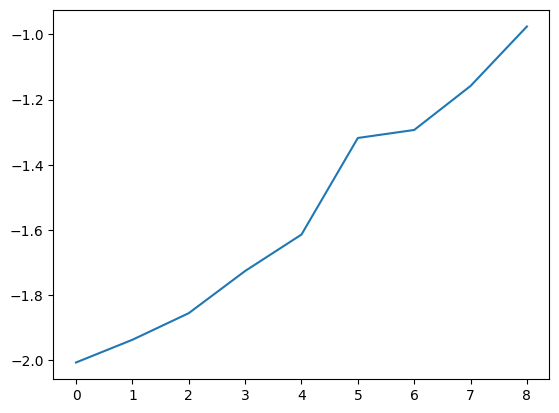

In [21]:
# Shapes

# num_geoms, num_ks_iterations, num_grids
print(states.density.shape)
# num_geoms, num_ks_iterations
print(states.total_energy.shape)

# Plot the states
plt.plot(states.total_energy[:, -1])
plt.show()

## Plotting the results 
The results are all stored in the states object.

In [22]:
states.total_energy

Array([[-2.00618065, -2.00720773, -2.00734692, -2.00737315, -2.00737941,
        -2.00738121, -2.00738181, -2.00738204, -2.00738214, -2.00738218,
        -2.0073822 , -2.00738222, -2.00738222, -2.00738223, -2.00738223],
       [-1.9360641 , -1.93745281, -1.93762715, -1.93765837, -1.93766554,
        -1.93766753, -1.93766818, -1.93766843, -1.93766853, -1.93766857,
        -1.93766859, -1.9376686 , -1.93766861, -1.93766862, -1.93766862],
       [-1.85367388, -1.855693  , -1.85591972, -1.85595748, -1.85596569,
        -1.85596787, -1.85596856, -1.85596881, -1.85596891, -1.85596895,
        -1.85596897, -1.85596898, -1.85596899, -1.85596899, -1.855969  ],
       [-1.72230947, -1.72609505, -1.72642886, -1.72647665, -1.72648591,
        -1.72648817, -1.72648883, -1.72648905, -1.72648913, -1.72648917,
        -1.72648919, -1.7264892 , -1.7264892 , -1.7264892 , -1.7264892 ],
       [-1.60745463, -1.61407223, -1.61450546, -1.61455738, -1.6145662 ,
        -1.61456813, -1.61456865, -1.61456881, 

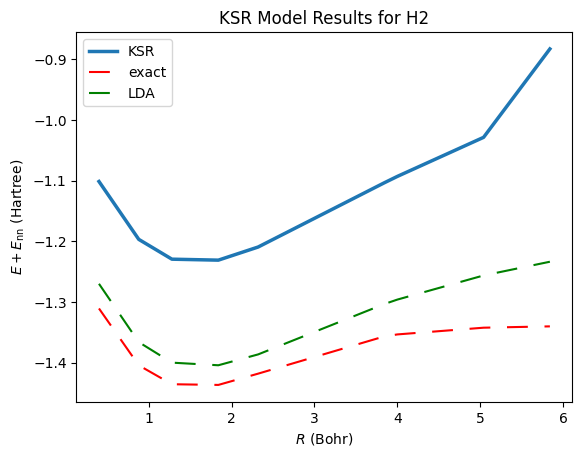

In [23]:
# Quick plot of the Kohn-Sham energy
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + states.total_energy[:, -1], lw=2.5, label='KSR')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + plot_set.total_energy,
    c='r', dashes=(10, 8), label='exact')
plt.plot(
    np.array(plot_distances) / 100,
    nuclear_energy + lda_states.total_energy[:, -1],
    c='g', dashes=(10, 8), label='LDA')
plt.title(f"KSR Model Results for H2")
plt.xlabel(r'$R\,\,\mathrm{(Bohr)}$')
plt.ylabel(r'$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$')
plt.legend(loc=0)
plt.show()

## Plots with errors

In [24]:
# This is the KohnShamState class that stores the state of the Kohn-Sham calculation
from jax_dft.scf import KohnShamState

[(0.986509, 0.822401, 0.143557), (0.991985, 0.681179, 0.195295), (0.963203, 0.553865, 0.271909), (0.907365, 0.434524, 0.35297), (0.836801, 0.329105, 0.430905), (0.752312, 0.227133, 0.513149), (0.650746, 0.125309, 0.595617), (0.523633, 0.024532, 0.652901), (0.387183, 0.001434, 0.654177), (0.241396, 0.014979, 0.610259)]


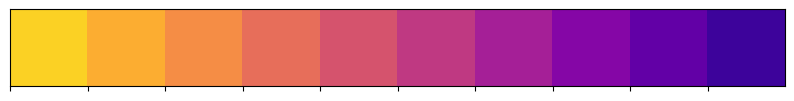

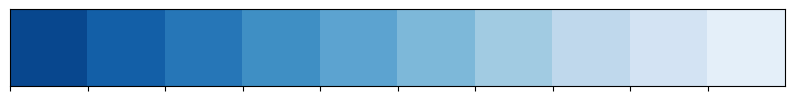

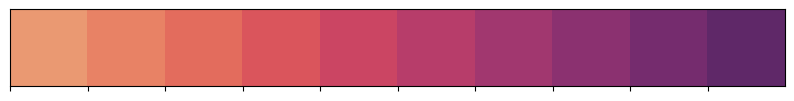

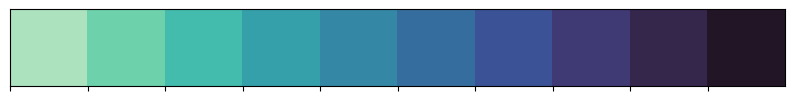

In [25]:
from qedft.utils.plot import PlotStyle
import seaborn as sns

# In plotter we can set a general palette
style = PlotStyle(palette_name="plasma_r", palette_size=10)
# Palletes of seaborn
print(style.palette)

# Palletes used in the paper
sns.palplot(sns.color_palette("plasma_r", 10))
sns.palplot(sns.color_palette("Blues_r", 10))
sns.palplot(sns.color_palette("flare", 10))
sns.palplot(sns.color_palette("mako_r", 10))

In [26]:
# Change the plot_results function to adjust
def plot_results(
    plot_distances,
    nuclear_energy,
    states,
    plot_set,
    title=None,
    save_path=None,
    show_legend=True
):
    """
    Create a comprehensive plot for KSR model results.

    Parameters:
    -----------
    plot_distances : array-like
        The interatomic distances for plotting
    nuclear_energy : array-like
        Nuclear interaction energies
    states : KohnShamState
        KohnShamState object containing model results
    plot_set : object
        Dataset object containing exact/reference values
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save the figure
    show_legend : bool, optional
        Whether to show the legend
    """
    from qedft.utils.plot import PlotStyle
    from matplotlib import pyplot as plt
    import numpy as np

    # Initialize plot style with a nice color palette
    style = PlotStyle(palette_name="mako_r", palette_size=10)

    # Create figure with 3 subplots (energy, energy error, density error)
    fig, axs = plt.subplots(
        3,
        sharex=True,
        sharey=False,
        gridspec_kw={"height_ratios": [3, 1, 1]}
    )
    fig.set_size_inches(6, 8)

    # Convert distances to Bohr if needed
    distances = np.array(plot_distances) / 100 if np.max(plot_distances) > 10 else np.array(plot_distances)

    # Plot limits
    xlim = (min(distances) * 0.9, max(distances) * 1.05)

    # Extract exact energies from plot_set
    exact_energies = plot_set.total_energy

    # Calculate model energies and errors
    model_energies = nuclear_energy + states.total_energy[:, -1]
    energy_errors = np.abs(model_energies - (nuclear_energy + exact_energies))

    lda_energies = nuclear_energy + lda_states.total_energy[:, -1]
    energy_errors_lda = np.abs(lda_energies - (nuclear_energy + exact_energies))

    # Check if exact densities are available
    has_exact_densities = hasattr(plot_set, 'density')

    # Calculate density errors if exact densities are provided
    if has_exact_densities:
        exact_densities = plot_set.density
        # Assuming states.density has shape (n_distances, n_iterations, n_grid_points)
        final_densities = states.density[:, -1, :]
        density_errors = np.mean((final_densities - exact_densities)**2, axis=1)

    # Calculate LDA density errors if exact densities are provided
    if has_exact_densities:
        exact_densities = plot_set.density
        final_lda_densities = lda_states.density[:, -1, :]
        lda_density_errors = np.mean((final_lda_densities - exact_densities)**2, axis=1)

    # ---- Plot 1: Total Energy ----
    style.setup_axis(
        axs[0],
        xlim=xlim,
        ylabel=r"$E+E_\mathrm{nn}\,\,\mathsf{(Hartree)}$",
        xtick_spacing=1.0,
    )

    # Plot model energy
    style.plot_curve(
        axs[0],
        distances,
        model_energies,
        label="KSR",
        color_idx=4,
        linewidth=2.5,
    )

    # plt.plot(
    # np.array(plot_distances) / 100,
    # nuclear_energy + lda_states.total_energy[:, -1],
    # c='g', dashes=(10, 8), label='LDA')

    # Plot LDA energy
    style.plot_curve(
        axs[0],
        distances,
        nuclear_energy + lda_states.total_energy[:, -1],
        label="LDA",
        color_idx=4,
        linewidth=2.5,
        linestyle="-.",
        color="gray",
    )
    style.plot_curve(
        axs[0],
        distances,
        nuclear_energy + exact_energies,
        label="Exact",
        color="black",
        linestyle="--",
    )

    if show_legend:
        axs[0].legend(loc='best', framealpha=0.5, frameon=False)

    # ---- Plot 2: Energy Error ----
    style.setup_axis(
        axs[1],
        xlim=xlim,
        ylabel=r"$|\Delta E|\,\,\mathsf{(Hartree)}$",
        yscale="log",
        xtick_spacing=1.0,
    )

    style.plot_curve(
        axs[1],
        distances,
        energy_errors,
        label="Energy Error",
        color_idx=4,
        linewidth=2.5,
    )

    # Plot LDA energy error
    style.plot_curve(
        axs[1],
        distances,
        energy_errors_lda,
        label="LDA Energy Error",
        color_idx=4,
        linestyle="-.",
        color="gray",
        linewidth=2.5,
    )

    # Add chemical accuracy reference line
    style.add_reference_line(axs[1], horizontal=0.0016)
    style.add_highlight_region(
        axs[1],
        ymin=0,
        ymax=0.0016,
        label="chemical accuracy",
    )

    # ---- Plot 3: Density Error (if available) ----
    if has_exact_densities:
        style.setup_axis(
            axs[2],
            xlim=xlim,
            ylabel=r"MSE($n$)",
            xlabel=r"$R\,\,\mathrm{(Bohr)}$",
            yscale="log",
            xtick_spacing=1.0,
        )

        style.plot_curve(
            axs[2],
            distances,
            density_errors,
            label="Density Error",
            color_idx=4,
            linewidth=2.5,
        )

        # Plot LDA density error
        style.plot_curve(
            axs[2],
            distances,
            lda_density_errors,
            label="LDA Density Error",
            color="gray",
            linestyle="-.",
            color_idx=4,
            linewidth=2.5,
        )
    else:
        # If no density data, just set up the axis
        style.setup_axis(
            axs[2],
            xlim=xlim,
            ylabel="",
            xlabel=r"$R\,\,\mathrm{(Bohr)}$",
            xtick_spacing=1.0,
        )
        axs[2].text(0.5, 0.5, "No density data available",
                   horizontalalignment='center', verticalalignment='center',
                   transform=axs[2].transAxes)

    # Add title if provided
    if title:
        fig.suptitle(title, fontsize=14)

    # Adjust layout
    fig.tight_layout()

    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig, axs

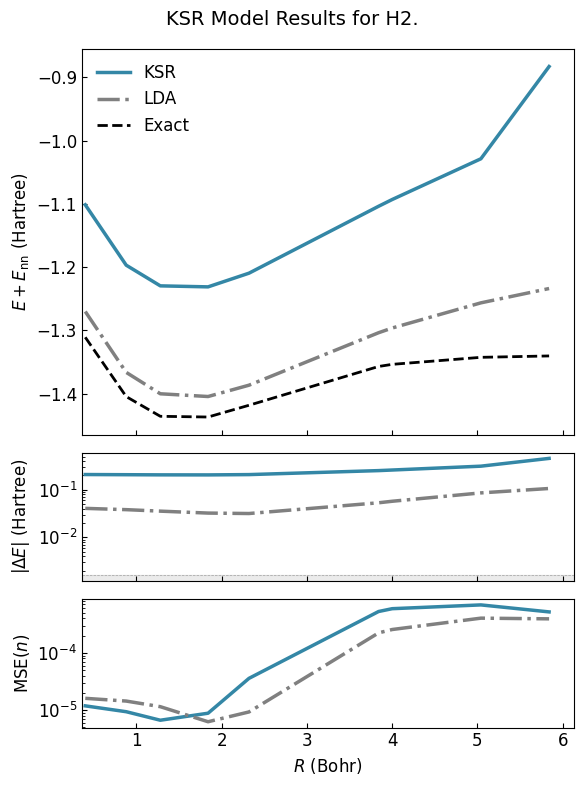

In [27]:
# Extract exact densities if available
try:
    exact_densities = plot_set.density
except AttributeError:
    exact_densities = None

# Create the plot
fig, axs = plot_results(
    plot_distances=plot_distances,
    nuclear_energy=nuclear_energy,
    states=states,
    plot_set=plot_set,
    title=f"KSR Model Results for H2.",
    save_path="ksr_model_results.png",
)

# Summary

This notebook demonstrates training a Kohn-Sham model:

1. Configuration setup with parameters for model architecture, training, etc.
2. Loading molecular dataset for H2 molecule with grid size 513
3. Initializing neural network for exchange-correlation energy density
4. Testing direct initialization networks with random inputs
5. Creating and training Kohn-Sham model:
   - Setting up Kohn-Sham function and batching
   - Initializing loss function
   - Creating training step with gradient computation
   - Optimizing using L-BFGS-B algorithm
6. Plotting the energy of the Kohn-Sham calculation for a given distance(s).